# Simple AR baseline

## Импорт необходимых библиотек

In [9]:
a = 1
print(a)

1


In [1]:
import datetime
from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator

import pandas as pd
import pandas_datareader.data as pdr

#!pip install fix_yahoo_finance --upgrade --quiet
import fix_yahoo_finance as yf
yf.pdr_override()

#!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip --upgrade --quiet
from mpl_finance import candlestick_ohlc

from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

## Получение исторических данных EUR-USD из Yahoo! Finance

In [2]:
startDate = "2003-12-01"
endDate = date.today()

eurusd = pdr.get_data_yahoo("EURUSD=X", start=startDate, end=endDate)
eurusd.to_csv("DATA/eurusd.csv", index=True)

[*********************100%***********************]  1 of 1 downloaded


Характеристики полученного набора

In [3]:
print("Number of rows: ", eurusd.shape[0])
eurusd.info()

Number of rows:  3946
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3946 entries, 2003-12-01 to 2019-02-25
Data columns (total 6 columns):
Open         3946 non-null float64
High         3946 non-null float64
Low          3946 non-null float64
Close        3946 non-null float64
Adj Close    3946 non-null float64
Volume       3946 non-null int32
dtypes: float64(5), int32(1)
memory usage: 200.4 KB


Пример заполнения набора данных

In [4]:
eurusd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0


График цен закрытия за всю историю

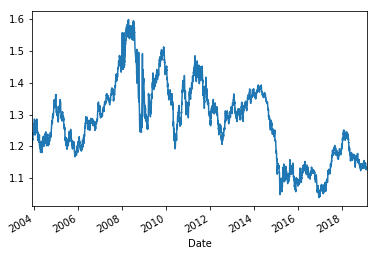

In [5]:
eurusd['Close'].plot()

## Свечной график (последние 3 месяца)

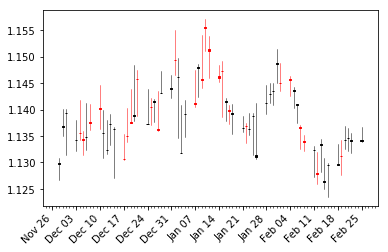

In [6]:
pltStartDate = pd.Timestamp(endDate - timedelta(days=90))
pltEndDate = pd.Timestamp(endDate)

pltDf = eurusd[(eurusd.index >= pltStartDate) & (eurusd.index <= pltEndDate)]

mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays = DayLocator()                  # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
ax.xaxis.set_major_formatter(weekFormatter)
# ax.xaxis.set_minor_formatter(dayFormatter)

candlestick_ohlc(ax, zip(mdates.date2num(pltDf.index.to_pydatetime()),
                         pltDf['Open'], pltDf['High'],
                         pltDf['Low'], pltDf['Close']),
                 width=0.6)

ax.xaxis_date()
ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

## Пример использования statsmodels.tsa.ar_model

Модель обучается на 30 последних значений, предсказывает 7 следующих. <br>
Лаг рассчитывается автоматически.

Лаг: 8
Коэф-ты:  [ 2.93510229 -0.19756502  0.34278648  0.17748531 -0.35773092 -0.07852442
 -0.2613171  -0.42548297 -0.77453212]
Предск. зн. = 1.138867; Реал. зн. = 1.129535
Предск. зн. = 1.141374; Реал. зн. = 1.129803
Предск. зн. = 1.147190; Реал. зн. = 1.131196
Предск. зн. = 1.155058; Реал. зн. = 1.134301
Предск. зн. = 1.153658; Реал. зн. = 1.134636
Предск. зн. = 1.158753; Реал. зн. = 1.134301
Предск. зн. = 1.151811; Реал. зн. = 1.134224


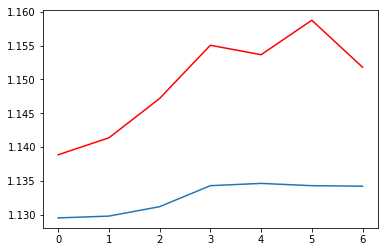

In [7]:
X =  eurusd['Close'].values
train, test = X[len(X)-30:len(X)-7], X[len(X)-7:]

model = AR(train)
model_fit = model.fit()
print('Лаг:', model_fit.k_ar)
print('Коэф-ты: ', model_fit.params)

predictions = model_fit.predict(start=len(train), 
                                end=len(train)+len(test)-1, 
                                dynamic=False)

for i in range(len(predictions)):
    print('Предск. зн. = %f; Реал. зн. = %f' % (predictions[i], test[i]))

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()